In [1]:
import requests
import simplejson as json
import pandas as pd
import urllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from joblib import Parallel, delayed
%matplotlib inline

## Mindcontrol Rating Scale

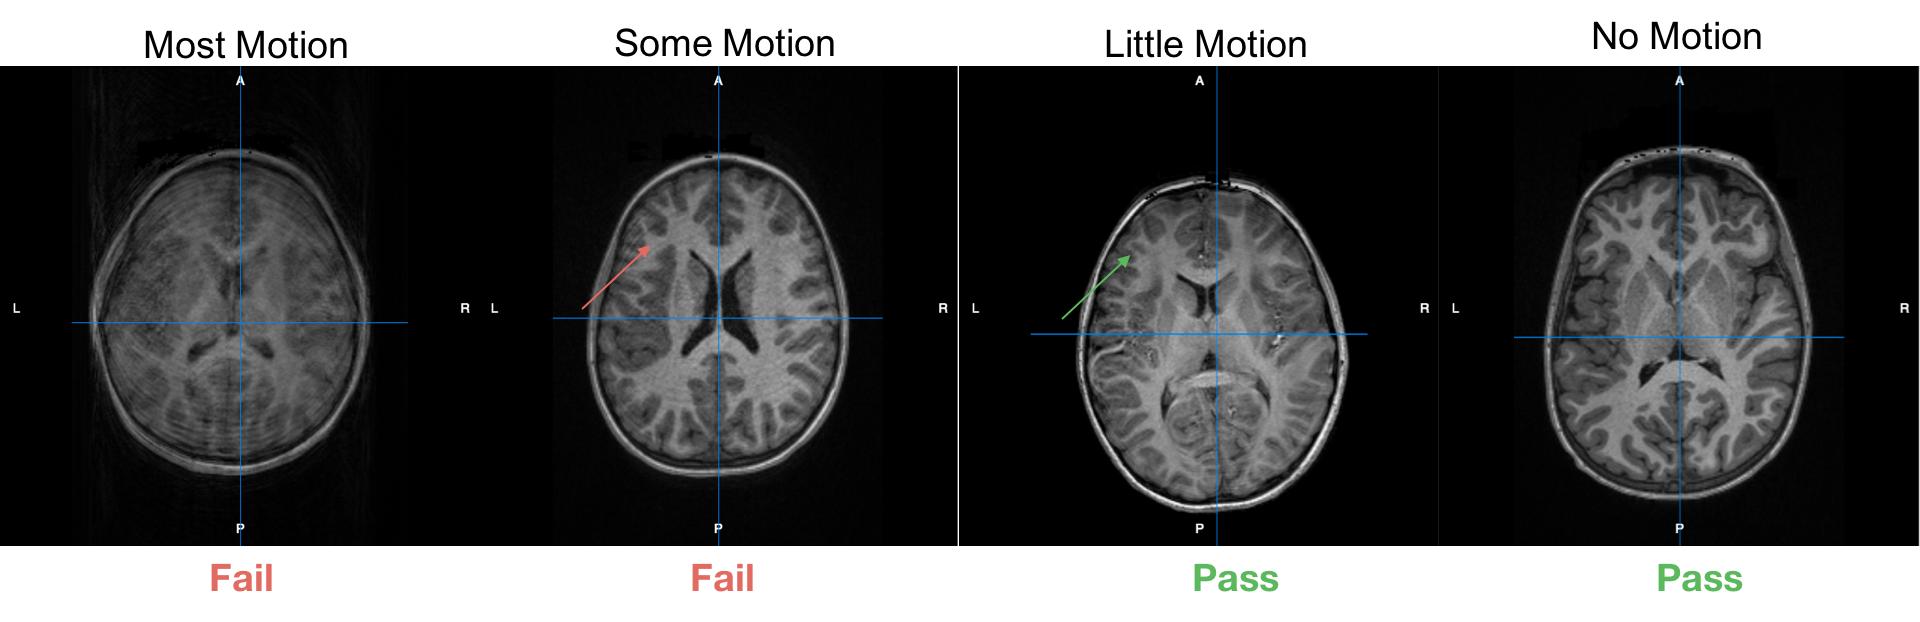

In [2]:
from IPython.display import Image
Image("http://mindcontrol-hbn.herokuapp.com/motion_QC.png")

### Get Mindcontrol Data & Gold Standard

In [3]:
url = "localhost:8080" #"52.176.100.238"
data = {"input_data":"https://s3-us-west-2.amazonaws.com/akeshavan-mindcontrol\
/braindr_data/mindcontrol-feb-21-18.json", 
 "truth_users": ["anisha", "dnkennedy", "amandae", "62442katieb"], 
       }#"threshold": 4}

labels_req = requests.post("http://{}/function/get-truth-labels".format(url), 
                           json.dumps(data))
labels = labels_req.json()

In [4]:
mindcontrol_df = pd.DataFrame(json.loads(labels['tidy_df']))
# mindcontrol_df = mindcontrol_df[mindcontrol_df.checkedBy.isin(data['truth_users'])]
stage1 = mindcontrol_df.groupby(['name','checkedBy']).apply(lambda x: x.mean()[['score']]).reset_index()
stage2 = stage1.groupby('name').apply(lambda x: x.mean()[['score']])
counts = stage1.groupby('name').apply(lambda x: x.count()[['score']])

In [5]:
counts.describe()

,score
count,724.000000
mean,1.494475
std,0.634397
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7.000000


## Mindcontrol Rating Distributions

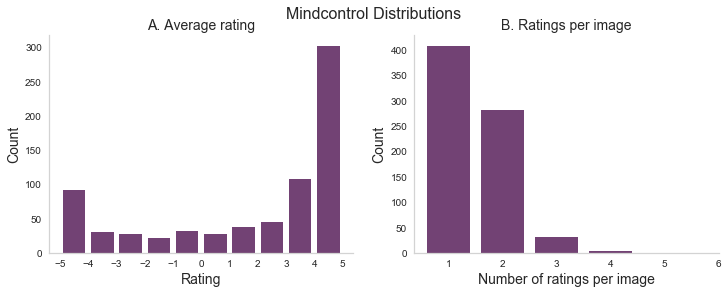

In [6]:
sns.set_style('white')
sns.set_palette(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.despine(fig)
colors = sns.cubehelix_palette(10, light=1)[::-1]

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

c,x,bars = ax[0].hist(stage2.score.values, rwidth=0.8, bins=10, color=colors[2]);
ax[0].set_xlabel('Rating', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
#ax[0].set_xticks([-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5,  1.5,  2.5,  3.5,  4.5,  5.5])
ax[0].set_xticks([-5, -4, -3, -2, -1,  0, 1,  2,  3,  4,  5])
ax[0].set_title('A. Average rating', fontsize=14)

ax[1].hist(counts.score.values, rwidth=0.8, bins = range(1,counts.score.max()), color=colors[2])
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_title('B. Ratings per image', fontsize=14)
ax[1].set_xlabel('Number of ratings per image', fontsize=14)
ax[1].set_xticks(np.arange(1, counts.score.max())+0.5)
ax[1].set_xticklabels(np.arange(1, counts.score.max()))

plt.suptitle('Mindcontrol Distributions', fontsize=16);
plt.savefig('MindcontrolDistributions.svg')

consolidate data for this image

In [7]:
data_mindcontrol_figure = {}
data_mindcontrol_figure['average_rating'] = stage2.reset_index().to_dict(orient="records")
data_mindcontrol_figure['n_ratings_per_image'] = counts.reset_index().to_dict(orient="records")

In [8]:
from nipype.utils.filemanip import save_json
save_json("data_mindcontrol_figure.json", data_mindcontrol_figure)

### get & aggregate braindr data

In [15]:
braindr_path = "https://dxugxjm290185.cloudfront.net/braindr_data/braindr_data_2-27-18.csv"

learning_rate = [0.01, 0.1]
n_estimators = [600]
max_depth = [2, 6]
test_size = 0.33

post_data = {"braindr_data": braindr_path,
             "pass_labels": labels['passing_names'],
             "fail_labels": labels['failing_names'],
             "learning_rates": learning_rate, 
             "n_estimators": n_estimators, 
             "max_depth": max_depth,
             "test_size": test_size}

base_url = 'localhost:8080'# "52.176.100.238"

agg_req = requests.post("http://{}/function/braindr-aggregator".format(base_url), 
                        json.dumps(post_data))

if not agg_req.ok:
    print("err", agg_req.text)
    print("reason", agg_req.reason)
else:
    agg_data = agg_req.json()

In [16]:
bdr_all = pd.read_csv(braindr_path, index_col=0)
bdr_full = pd.DataFrame(json.loads(agg_data['output']))
bdr_full['subject_id'] = bdr_full.index.map(lambda x: x.split("__")[0])
bdr_gold = pd.DataFrame(json.loads(agg_data['bdr_pivot']))

## Sample Images

In [17]:
np.random.seed(0)

In [18]:
def get_image(img):
    url = "https://s3-us-west-2.amazonaws.com/akeshavan-mindcontrol/braindr/{}.jpg".format(img)
    urllib.request.urlretrieve(url, 'tmp.jpg')
    return plt.imread('tmp.jpg')

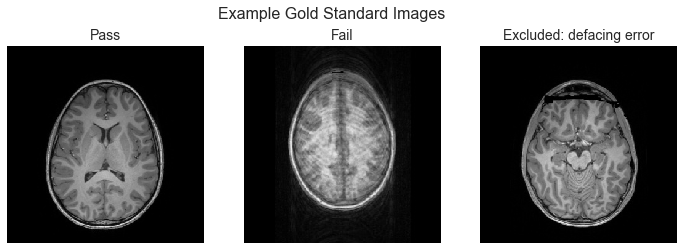

In [19]:
bad_deface = get_image(bdr_full[bdr_full.subject_id.isin(['sub-NDARWM527PRT_T1w'])].index.values[2])
good_ex = get_image(bdr_gold[bdr_gold.truth==1].index.values[10])
bad_ex = get_image(bdr_gold[bdr_gold.truth==0].index.values[10])

fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.despine(fig, top=True, bottom=True, right=True, left=True)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(good_ex)
ax[0].set_title("Pass", fontsize=14)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(bad_ex)
ax[1].set_title("Fail", fontsize=14)

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("Excluded: defacing error", fontsize=14)
ax[2].imshow(bad_deface);

plt.suptitle('Example Gold Standard Images', fontsize=16);
plt.savefig('ExampleGoldStandardImages.svg')

In [20]:
ls ExampleGoldStandardImages.svg

ExampleGoldStandardImages.svg


## Gold Standard Distributions

In [21]:
#remove a few non-rater columns from the bdr_gold dataframe
bdr_raters_df = bdr_gold[[c for c in bdr_gold.columns if not c in ['truth', 'plain_average']]]
# get a list of raters
bdr_raters = bdr_raters_df.columns
total_num_users = np.unique(bdr_all.username.values).shape[0]
print("Total Number of Users:", total_num_users)
print("Number of Gold Standard Raters: ", len(bdr_raters))
# filter the original dataframe for only these raters
bdr_raters_only = bdr_all[bdr_all.username.isin(bdr_raters)]
print("Total Number of Ratings: ", bdr_all.shape[0])
print("Number of Ratings from Gold Standard Raters: ", bdr_raters_only.shape[0])
#filter the original dataframe for raters & gold images
bdr_raters_gold = bdr_raters_only[bdr_raters_only.image_id.isin(bdr_gold.index)]
print("Number of Ratings on Gold Standard Images:", bdr_raters_gold.shape[0])

Total Number of Users: 261
Number of Gold Standard Raters:  65
Total Number of Ratings:  83164
Number of Ratings from Gold Standard Raters:  68314
Number of Ratings on Gold Standard Images: 18940


In [22]:
braindr_stats_dataset = {"Total Number of Users:": total_num_users,
    "Number of Gold Standard Raters: ": len(bdr_raters),
    "Total Number of Ratings: ": bdr_all.shape[0],
    "Number of Ratings from Gold Standard Raters: ": bdr_raters_only.shape[0],
    "Number of Ratings on Gold Standard Images:": bdr_raters_gold.shape[0]}

In [23]:
save_json("braindr_stats_dataset.json", braindr_stats_dataset)

In [24]:
mean_ratings = bdr_gold['plain_average']
counts_bdr = bdr_raters_gold.groupby('image_id').apply(lambda x: x.shape[0])

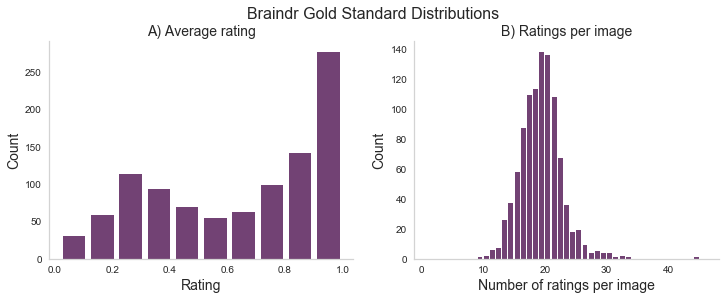

In [25]:
sns.set_style('white')
colors = sns.cubehelix_palette(10, light=1)[::-1]
# sns.set_palette(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')
sns.despine(fig)
c,x,bars = ax[0].hist(mean_ratings.values, rwidth=0.8, bins=10, color=colors[2]);
ax[0].set_xlabel('Rating', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
#ax[0].set_xticks([-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5,  1.5,  2.5,  3.5,  4.5,  5.5])
#ax[0].set_xticks([-5, -4, -3, -2, -1,  0, 1,  2,  3,  4,  5])
ax[0].set_title('A) Average rating', fontsize=14)

ax[1].hist(counts_bdr.values, rwidth=0.8, bins = range(1,counts_bdr.values.max()), color=colors[2])
ax[1].set_title('B) Ratings per image', fontsize=14)
ax[1].set_xlabel('Number of ratings per image', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)

#ax[1].set_xticks(np.arange(1, counts.values.max())+0.5)
#ax[1].set_xticklabels(np.arange(1, counts.values.max()))

plt.suptitle('Braindr Gold Standard Distributions', fontsize=16, y=1);
plt.savefig('BraindrGoldStandardDistributions.svg')

In [26]:
braindr_distribution_dataset = {}
braindr_distribution_dataset['average_rating'] = mean_ratings.reset_index().to_dict(orient='records')
braindr_distribution_dataset['counts'] = counts_bdr.reset_index().to_dict(orient='records')
save_json('braindr_distribution_dataset.json', braindr_distribution_dataset)

In [28]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(agg_data):
    fpr, tpr, t = roc_curve(np.asarray(agg_data['y_test'])==1, np.asarray(agg_data['y_pred_prob']))
    a = auc(fpr, tpr)
    
    df = pd.DataFrame(json.loads(agg_data['bdr_pivot']))
    fprt, tprt, tt = roc_curve(df.truth.values == 1, df.plain_average.values)
    aa = auc(fprt, tprt)
    output = dict(fpr=fpr, tpr=tpr, thresholds=t, auc=a, train_size=agg_data['X_train_shape'][0],
                  fpr_a=fprt, tpr_a=tprt, thresholds_a = tt, auc_a = aa)
    return output

output = get_roc_auc(agg_data)
print(output['auc'])

0.976884792627


## Braindr aggregation via XGBoost: How much data is needed?

In [29]:
def iterate_test_size(test_size):
    import requests
    
    braindr_path = "https://dxugxjm290185.cloudfront.net/braindr_data/braindr_data_2-27-18.csv"

    learning_rate = [0.01, 0.1]
    n_estimators = [600]
    max_depth = [2, 6]

    post_data = {"braindr_data": braindr_path,
             "pass_labels": labels['passing_names'],
             "fail_labels": labels['failing_names'],
             "learning_rates": learning_rate, 
             "n_estimators": n_estimators, 
             "max_depth": max_depth,
             "test_size": test_size}

    base_url = 'localhost:8080'# "52.176.100.238"
    
    agg_req = requests.post("http://{}/function/braindr-aggregator".format(base_url), 
                            json.dumps(post_data))

    if not agg_req.ok:
        print("err", agg_req.text)
        print("reason", agg_req.reason)
    else:
        agg_data = agg_req.json()
        return agg_data #get_roc_auc(agg_data)

In [30]:
test_sizes = [0.2, 0.33, 0.5, 0.75]

data_all = Parallel(n_jobs=2)(delayed(iterate_test_size)(i) for i in test_sizes)

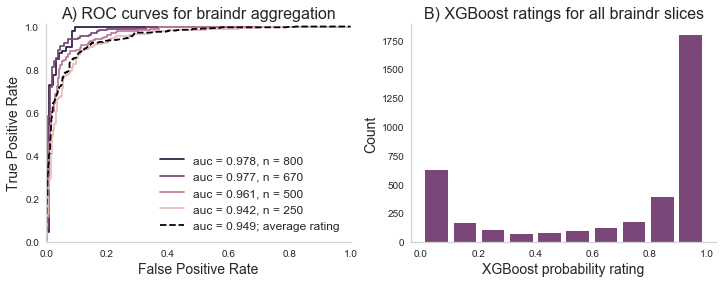

In [31]:
rocs = [get_roc_auc(d) for d in data_all]
#colors = sns.light_palette((210, 90, 60), input="husl")[::-1]
colors = sns.cubehelix_palette(5, light=1)[::-1]

with sns.color_palette(colors):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].spines['bottom'].set_color('lightgray')
    ax[0].spines['left'].set_color('lightgray')
    ax[1].spines['bottom'].set_color('lightgray')
    ax[1].spines['left'].set_color('lightgray')
    sns.despine(fig)
    for i, roc in enumerate(rocs):
        ax[0].plot(roc['fpr'], roc['tpr'])
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1.01])
        
    ax[0].plot(roc['fpr_a'], roc['tpr_a'], color="black", linestyle="--")
    ax[0].legend(["auc = %0.3f, n = %d" % (roc['auc'], 
                                        roc['train_size']) for roc in rocs] +\
              ["auc = %0.3f; average rating" % rocs[0]['auc_a']], loc=4, fontsize=12)
    ax[0].set_xlabel('False Positive Rate', fontsize=14)
    ax[0].set_ylabel('True Positive Rate', fontsize=14)
    ax[0].set_title("A) ROC curves for braindr aggregation", fontsize=16)
    
    output = pd.DataFrame(json.loads(agg_data['output']))
    ax[1].hist(output.xgboost_label.values, rwidth=0.8, color=colors[1])
    ax[1].set_xlabel('XGBoost probability rating', fontsize=14)
    ax[1].set_ylabel('Count', fontsize=14)
    ax[1].set_title('B) XGBoost ratings for all braindr slices', fontsize=16)

## XGBoost feature importances

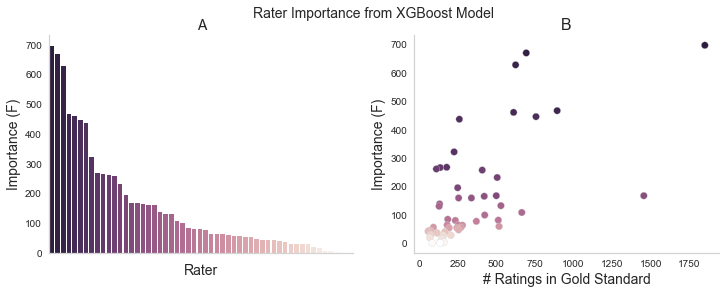

In [32]:
fdf = pd.DataFrame(json.loads(agg_data['user_importance']))
fdf.sort_values('F', inplace=True)
fdf.rename(columns={"user": "username"}, inplace=True)
fdf = fdf[::-1]
fdf['idx'] = np.arange(1, 1+fdf.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].spines['top'].set_visible(False)
#ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(True)

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(fdf.shape[0], light=1)[::-1]

ax[0].bar(np.arange(fdf.shape[0]), fdf.F.values, color=colors)
ax[0].set_xticks(np.arange(fdf.shape[0]))
ax[0].set_xticklabels([]) #fdf.idx.values, fontsize=8);
#ax[0].set_yticks([])
ax[0].set_xlabel("Rater", fontsize=14)
ax[0].set_ylabel("Importance (F)", fontsize=14)
ax[0].set_xlim([-0.5,fdf.shape[0]])
ax[0].set_title("A", fontsize=14)


sns.despine(ax=ax[1])

ucounts = bdr_raters_gold.groupby('username').apply(lambda x: x.shape[0])
fdf.set_index('username', inplace=True)
fdf['ucounts'] = ucounts

ax[1].scatter(fdf.ucounts.values, fdf.F.values, c=colors, edgecolors="lightgray")
ax[1].set_xlabel("# Ratings in Gold Standard", fontsize=14)
ax[1].set_ylabel("Importance (F)", fontsize=14)
ax[1].set_title("B", fontsize=16)


from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

plt.suptitle("Rater Importance from XGBoost Model", fontsize=14)
#for i, row in fdf.iterrows():
#  ax.text(row.F+1, idx-0.15, str(row.F))
#  idx +=1

In [33]:
for i, roc in enumerate(rocs):
    for key, value in roc.items():
        #rocs[i][key] 
        if isinstance(value, np.ndarray):
            rocs[i][key] = value.tolist()

In [34]:
braindr_xgboost_data = {}
braindr_xgboost_data['user_importances'] = fdf.astype(float).to_dict(orient='records')
braindr_xgboost_data['ratings'] = output[['xgboost_label']].reset_index().to_dict(orient='records')
braindr_xgboost_data['rocs'] = rocs
save_json("braindr_xgboost_data.json", braindr_xgboost_data)

## Deep Learning to predict XGBoost rating from slice

In [35]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras import applications
from skimage.color import convert_colorspace, gray2rgb

Using TensorFlow backend.


In [36]:
data = np.load('/mnt/scratch3/keshavan/braindr/data_1-26-18.npz')#'data_1-26-18.npz')
img_labels = pd.read_csv('https://s3-us-west-2.amazonaws.com/akeshavan-mindcontrol/braindr/braindr-1-26.csv', 
                         index_col=0)
img_labels['y_prob'] = output.xgboost_label
img_labels['subject'] = img_labels.index.map(lambda x:x.split("__")[0])

In [37]:
vgg_model = applications.VGG16(include_top=False, weights='imagenet', 
                           input_shape=(256,256,3))

In [38]:
bin_idx = img_labels.subject.isin(labels['not_including']) == False
img_labels = img_labels[bin_idx]
X = data['X'][bin_idx]
y = img_labels['y_prob']
X_rgb = gray2rgb(X[:,:,:,0])
X_vgg = vgg_model.predict(X_rgb)

In [39]:
def get_split_indices(subjects_all, seed=0):
    np.random.seed(seed)
    idx = list(range(len(set(subjects_all))))
    subjects = np.asarray(list(set(subjects_all)))
    np.random.shuffle(idx)
    train_subs = idx[:int(0.8*subjects.shape[0])]
    test_subs = idx[int(0.8*subjects.shape[0]):int(0.9*subjects.shape[0])]
    val_subs = idx[int(0.9*subjects.shape[0]):]
    train = [i for i, val in enumerate(subjects_all) if val in subjects[train_subs]]
    np.random.shuffle(train)
    test = [i for i, val in enumerate(subjects_all) if val in subjects[test_subs]]
    np.random.shuffle(test)
    val = [i for i, val in enumerate(subjects_all) if val in subjects[val_subs]]
    np.random.shuffle(val)
    return train, test, val

In [40]:
img_labels['idx'] = np.arange(img_labels.shape[0])
gold = pd.merge(img_labels[['idx']], bdr_gold[['truth', 'plain_average']], 
                left_index=True, right_index=True)

In [41]:
def get_vgg_top_model(bottleneck_features_train, lr=1e-4):
    # A very simple model to train 1 final layer to combine the features from VGG16
    vggtop_model = Sequential()
    vggtop_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
    vggtop_model.add(Dense(256, activation='relu'))
    vggtop_model.add(Dropout(0.5))
    vggtop_model.add(Dense(1, activation='sigmoid'))

    vggtop_model.compile(optimizer=Adam(lr=lr),
                  loss='mean_squared_error', metrics=['accuracy'])
    return vggtop_model

In [42]:
def run_model(i=0):
    # i is a random seed. This is set on the Tensorflow end on & the numpy end
    tf.set_random_seed(i)
    
    batch_size = 16
    epochs = 50
    filename = "/mnt/scratch3/keshavan/braindr_vgg16/training%04d.csv" % i
    filepath = "/mnt/scratch3/keshavan/braindr_vgg16/best_model%04d.h5" % i

    # get split indices, as a function of random seed
    train_idx, test_idx, val_idx = get_split_indices(img_labels.subject.values, i)
    X_train, y_train, X_test, y_test, X_val, y_val = X_vgg[train_idx,:,:,:], y[train_idx], X_vgg[test_idx,:,:,:], y[test_idx], X_vgg[val_idx,:,:,:], y[val_idx]
    print(X_train.shape, X_test.shape, X_val.shape)
    
    gold['in_test'] = gold.idx.isin(test_idx+val_idx)
    gold_in = gold[gold.in_test]
    
    X_gold = X_vgg[gold_in['idx'].values]
    y_gold = gold_in['truth'].values
    
    vggtop_model = get_vgg_top_model(X_train, 1e-4)

    best_model = keras.callbacks.ModelCheckpoint(filepath, 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto',
                                    period=1)

    csv_logger = keras.callbacks.CSVLogger(filename, separator=',', append=False)

    callbacks = [best_model, csv_logger]

    vggtop_model.fit(X_train, y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, verbose=1, 
                     callbacks = callbacks,
                     validation_data=(X_val, y_val))

    print(best_model.model.evaluate(X_gold, y_gold))
    y_gold_pred = best_model.model.predict(X_gold)
    gold_in['y_pred'] = y_gold_pred
    fpr_gold, tpr_gold, thresh_gold = roc_curve(y_gold, y_gold_pred)
    gold_auc = auc(fpr_gold, tpr_gold)
    print(gold_auc)
    return dict(model=best_model.model, fpr=fpr_gold, tpr=tpr_gold, 
                threshold=thresh_gold, auc=gold_auc, training=pd.read_csv(filename),
                best_model=filepath, train_shape = X_train.shape, 
                test_shape = X_test.shape, val_shape = X_val.shape, 
                test_idx=test_idx, train_idx=train_idx, val_idx=val_idx, 
                gold_test=gold_in, gold_idx=gold['idx'].values)

In [43]:
results = run_model(0)

(2858, 8, 8, 512) (354, 8, 8, 512) (360, 8, 8, 512)
Train on 2858 samples, validate on 360 samples
Epoch 1/50
2858/2858 [==============================] - 13s - loss: 0.0929 - acc: 0.0000e+00 - val_loss: 0.0719 - val_acc: 0.0000e+00
Epoch 2/50
2858/2858 [==============================] - 1s - loss: 0.0688 - acc: 0.0000e+00 - val_loss: 0.0676 - val_acc: 0.0000e+00
Epoch 3/50
2858/2858 [==============================] - 1s - loss: 0.0645 - acc: 0.0000e+00 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 4/50
2858/2858 [==============================] - 1s - loss: 0.0584 - acc: 0.0000e+00 - val_loss: 0.0639 - val_acc: 0.0000e+00
Epoch 5/50
2858/2858 [==============================] - 1s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0646 - val_acc: 0.0000e+00
Epoch 6/50
2858/2858 [==============================] - 1s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 7/50
2858/2858 [==============================] - 1s - loss: 0.0536 - acc: 0.0000e+00 - val_loss

/home/keshavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
all_predicted = results['model'].predict(X_vgg)

In [45]:
img_labels['predicted_label'] = all_predicted

In [46]:
all_results = []

for i in range(1,10):
    r = run_model(i)
    all_results.append(r)

(2857, 8, 8, 512) (355, 8, 8, 512) (360, 8, 8, 512)
Train on 2857 samples, validate on 360 samples
Epoch 1/50
2857/2857 [==============================] - 1s - loss: 0.0896 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 2/50
2857/2857 [==============================] - 1s - loss: 0.0664 - acc: 0.0000e+00 - val_loss: 0.0661 - val_acc: 0.0000e+00
Epoch 3/50
2857/2857 [==============================] - 1s - loss: 0.0648 - acc: 0.0000e+00 - val_loss: 0.0795 - val_acc: 0.0000e+00
Epoch 4/50
2857/2857 [==============================] - 1s - loss: 0.0624 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 5/50
2857/2857 [==============================] - 1s - loss: 0.0581 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 6/50
2857/2857 [==============================] - 1s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0523 - val_acc: 0.0000e+00
Epoch 7/50
2857/2857 [==============================] - 1s - loss: 0.0551 - acc: 0.0000e+00 - val_loss:

/home/keshavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2857, 8, 8, 512) (355, 8, 8, 512) (360, 8, 8, 512)
Train on 2857 samples, validate on 360 samples
Epoch 1/50
2857/2857 [==============================] - 1s - loss: 0.0968 - acc: 0.0000e+00 - val_loss: 0.0696 - val_acc: 0.0000e+00
Epoch 2/50
2857/2857 [==============================] - 1s - loss: 0.0708 - acc: 0.0000e+00 - val_loss: 0.0688 - val_acc: 0.0000e+00
Epoch 3/50
2857/2857 [==============================] - 1s - loss: 0.0661 - acc: 0.0000e+00 - val_loss: 0.0661 - val_acc: 0.0000e+00
Epoch 4/50
2857/2857 [==============================] - 1s - loss: 0.0607 - acc: 0.0000e+00 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 5/50
2857/2857 [==============================] - 1s - loss: 0.0614 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 6/50
2857/2857 [==============================] - 1s - loss: 0.0575 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 7/50
2857/2857 [==============================] - 1s - loss: 0.0574 - acc: 0.0000e+00 - val_loss:

2858/2858 [==============================] - 1s - loss: 0.0508 - acc: 0.0000e+00 - val_loss: 0.0526 - val_acc: 0.0000e+00
Epoch 10/50
2858/2858 [==============================] - 1s - loss: 0.0508 - acc: 0.0000e+00 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 11/50
2858/2858 [==============================] - 1s - loss: 0.0483 - acc: 0.0000e+00 - val_loss: 0.0514 - val_acc: 0.0000e+00
Epoch 12/50
2858/2858 [==============================] - 1s - loss: 0.0472 - acc: 0.0000e+00 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 13/50
2858/2858 [==============================] - 1s - loss: 0.0463 - acc: 0.0000e+00 - val_loss: 0.0503 - val_acc: 0.0000e+00
Epoch 14/50
2858/2858 [==============================] - 1s - loss: 0.0469 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 15/50
2858/2858 [==============================] - 1s - loss: 0.0472 - acc: 0.0000e+00 - val_loss: 0.0505 - val_acc: 0.0000e+00
Epoch 16/50
2858/2858 [==============================] - 1s - loss: 0.0437

2857/2857 [==============================] - 1s - loss: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0624 - val_acc: 0.0000e+00
Epoch 19/50
2857/2857 [==============================] - 1s - loss: 0.0450 - acc: 0.0000e+00 - val_loss: 0.0639 - val_acc: 0.0000e+00
Epoch 20/50
2857/2857 [==============================] - 1s - loss: 0.0422 - acc: 0.0000e+00 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 21/50
2857/2857 [==============================] - 1s - loss: 0.0416 - acc: 0.0000e+00 - val_loss: 0.0758 - val_acc: 0.0000e+00
Epoch 22/50
2857/2857 [==============================] - 1s - loss: 0.0413 - acc: 0.0000e+00 - val_loss: 0.0654 - val_acc: 0.0000e+00
Epoch 23/50
2857/2857 [==============================] - 1s - loss: 0.0399 - acc: 0.0000e+00 - val_loss: 0.0677 - val_acc: 0.0000e+00
Epoch 24/50
2857/2857 [==============================] - 1s - loss: 0.0412 - acc: 0.0000e+00 - val_loss: 0.0685 - val_acc: 0.0000e+00
Epoch 25/50
2857/2857 [==============================] - 1s - loss: 0.0390

2858/2858 [==============================] - 1s - loss: 0.0373 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 28/50
2858/2858 [==============================] - 1s - loss: 0.0362 - acc: 0.0000e+00 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 29/50
2858/2858 [==============================] - 1s - loss: 0.0365 - acc: 0.0000e+00 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 30/50
2858/2858 [==============================] - 1s - loss: 0.0354 - acc: 0.0000e+00 - val_loss: 0.0483 - val_acc: 0.0000e+00
Epoch 31/50
2858/2858 [==============================] - 1s - loss: 0.0350 - acc: 0.0000e+00 - val_loss: 0.0486 - val_acc: 0.0000e+00
Epoch 32/50
2858/2858 [==============================] - 1s - loss: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 33/50
2858/2858 [==============================] - 1s - loss: 0.0331 - acc: 0.0000e+00 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 34/50
2858/2858 [==============================] - 1s - loss: 0.0339

2858/2858 [==============================] - 1s - loss: 0.0342 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 37/50
2858/2858 [==============================] - 1s - loss: 0.0332 - acc: 0.0000e+00 - val_loss: 0.0500 - val_acc: 0.0000e+00
Epoch 38/50
2858/2858 [==============================] - 1s - loss: 0.0326 - acc: 0.0000e+00 - val_loss: 0.0476 - val_acc: 0.0000e+00
Epoch 39/50
2858/2858 [==============================] - 1s - loss: 0.0348 - acc: 0.0000e+00 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 40/50
2858/2858 [==============================] - 1s - loss: 0.0328 - acc: 0.0000e+00 - val_loss: 0.0509 - val_acc: 0.0000e+00
Epoch 41/50
2858/2858 [==============================] - 1s - loss: 0.0315 - acc: 0.0000e+00 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 42/50
2858/2858 [==============================] - 1s - loss: 0.0328 - acc: 0.0000e+00 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 43/50
2858/2858 [==============================] - 1s - loss: 0.0306

2859/2859 [==============================] - 1s - loss: 0.0273 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 46/50
2859/2859 [==============================] - 1s - loss: 0.0286 - acc: 0.0000e+00 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 47/50
2859/2859 [==============================] - 1s - loss: 0.0298 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+00
Epoch 48/50
2859/2859 [==============================] - 1s - loss: 0.0275 - acc: 0.0000e+00 - val_loss: 0.0630 - val_acc: 0.0000e+00
Epoch 49/50
2859/2859 [==============================] - 1s - loss: 0.0261 - acc: 0.0000e+00 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epoch 50/50
 32/165 [====>.........................] - ETA: 0s[0.082879182425412271, 0.89090909099940097]
0.959365079365
(2858, 8, 8, 512) (354, 8, 8, 512) (360, 8, 8, 512)
Train on 2858 samples, validate on 360 samples
Epoch 1/50
2858/2858 [==============================] - 2s - loss: 0.0982 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 

2857/2857 [==============================] - 1s - loss: 0.0637 - acc: 0.0000e+00 - val_loss: 0.0853 - val_acc: 0.0000e+00
Epoch 4/50
2857/2857 [==============================] - 1s - loss: 0.0606 - acc: 0.0000e+00 - val_loss: 0.0793 - val_acc: 0.0000e+00
Epoch 5/50
2857/2857 [==============================] - 1s - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0659 - val_acc: 0.0000e+00
Epoch 6/50
2857/2857 [==============================] - 1s - loss: 0.0581 - acc: 0.0000e+00 - val_loss: 0.0743 - val_acc: 0.0000e+00
Epoch 7/50
2857/2857 [==============================] - 1s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0643 - val_acc: 0.0000e+00
Epoch 8/50
2857/2857 [==============================] - 1s - loss: 0.0530 - acc: 0.0000e+00 - val_loss: 0.0637 - val_acc: 0.0000e+00
Epoch 9/50
2857/2857 [==============================] - 1s - loss: 0.0513 - acc: 0.0000e+00 - val_loss: 0.0706 - val_acc: 0.0000e+00
Epoch 10/50
2857/2857 [==============================] - 1s - loss: 0.0501 - acc

In [47]:
k = [a['auc'] for a in all_results + [results]]
print(np.mean(k), np.std(k))

0.989625717222 0.0115118922616


In [48]:
a = all_results[0]['train_idx']
b = all_results[1]['train_idx']

In [49]:
# Make sure the training sets for different seed runs actually have different subjects
assert ~np.asarray([i in b for i in a]).all()

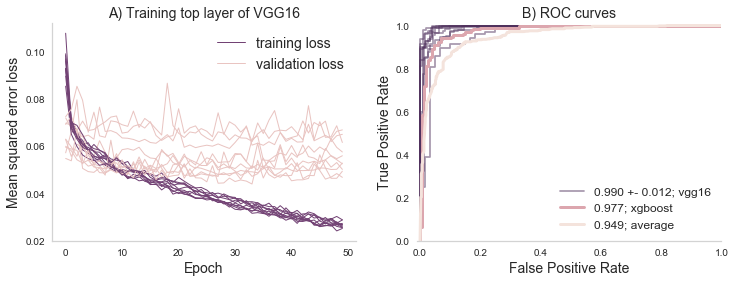

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(10, light=1)[::-1]

sns.despine(fig)
for i, a in enumerate(all_results + [results]):
    if not i:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1], 
                   label="%0.3f +- %0.3f; vgg16" % (np.mean(k), np.std(k)))
    else:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1])

    
    
ax[1].plot(rocs[1]['fpr'], rocs[1]['tpr'],color=colors[6], 
           label="%0.3f; xgboost" % rocs[1]['auc'], linewidth=3)
ax[1].plot(rocs[1]['fpr_a'], rocs[1]['tpr_a'], color=colors[8], 
           label="%0.3f; average" % rocs[1]['auc_a'], linewidth=3)
ax[1].set_xlim([-0.01,1])
ax[1].set_ylim([0,1.01])
ax[1].legend(fontsize=12, loc=4)
ax[1].spines['left'].set_visible(False)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel("True Positive Rate", fontsize=14)
ax[1].set_title("B) ROC curves", fontsize=14)
    
tdf = results['training']
ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])
ax[0].legend(fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Mean squared error loss', fontsize=14)
ax[0].set_title("A) Training top layer of VGG16", fontsize=14)

for res in all_results:
    tdf = res['training']
    ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
    ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])

In [56]:
results.keys()

dict_keys(['model', 'fpr', 'tpr', 'threshold', 'auc', 'training', 'best_model', 'train_shape', 'test_shape', 'val_shape', 'test_idx', 'train_idx', 'val_idx', 'gold_test', 'gold_idx'])

In [62]:
braindr_vgg_train = {'vgg': [], 'crowd': rocs[1]}
for a in all_results + [results]:
    entry = {}
    for key in ['fpr', 'tpr', 'threshold', 'auc']:
        try:
            entry[key] = a[key].tolist()
        except:
            entry[key] = a[key]
    entry['training'] = a['training'].to_json(orient="records")
    braindr_vgg_train['vgg'].append(entry)
save_json("../src/assets/braindr_vgg_results.json", braindr_vgg_train)

In [181]:
def reshape_to_3D_labels(df):
    df['subject'] = df.index.map(lambda x: x.split("__")[0])
    df['slice_num'] = df.index.map(lambda x: int(x.split("_")[-1]))
    df.sort_values(['subject', 'slice_num'], inplace=True)
    for sub, subdf in df.groupby('subject'):
        df.loc[df.subject==sub, 'slice_idx'] = np.arange(subdf.shape[0]).tolist()
    return df

In [182]:
reshape_to_3D_labels(img_labels);

In [223]:
to3D = img_labels.pivot_table(columns=['slice_idx'], index=['subject'], values=['predicted_label'])
X_to3D = to3D['predicted_label'].values
print(X_to3D.shape)
#to3D['label_3D_xg'] = res_labelpred['model'].predict_proba(X_to3D)[:,1]
to3D['label_3D_avg'] = to3D['predicted_label'].mean(1)
to3D.head()

(715, 5)


predicted_label                                          \
slice_idx                        0.0       1.0       2.0       3.0       4.0   
subject                                                                        
sub-NDARAA075AMK_T1w        0.942518  0.765796  0.708444  0.893305  0.922348   
sub-NDARAA536PTU_T1w        0.972949  0.957473  0.963045  0.963418  0.925621   
sub-NDARAA948VFH_T1w        0.952820  0.975015  0.908336  0.966597  0.951152   
sub-NDARAC853DTE_T1w        0.093308  0.093928  0.004418  0.003276  0.031169   
sub-NDARAC904DMU_T1w        0.090159  0.026505  0.024158  0.008716  0.014594   

                     label_3D_avg  
slice_idx                          
subject                            
sub-NDARAA075AMK_T1w     0.846482  
sub-NDARAA536PTU_T1w     0.956501  
sub-NDARAA948VFH_T1w     0.950784  
sub-NDARAC853DTE_T1w     0.045220  
sub-NDARAC904DMU_T1w     0.032826

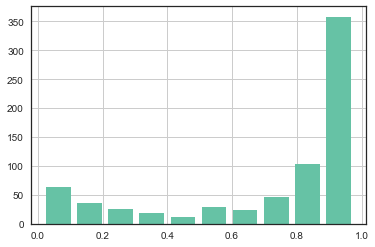

In [224]:
to3D.label_3D_avg.hist(rwidth=0.8)

In [220]:
to3D['isGold'] = to3D.index.isin(labels['passing_names']+labels['failing_names'])
to3D.loc[to3D.index.isin(labels['passing_names']), 'truth'] = 1
to3D.loc[to3D.index.isin(labels['failing_names']), 'truth'] = 0
to3D.head()

predicted_label                                          \
slice_idx                        0.0       1.0       2.0       3.0       4.0   
subject                                                                        
sub-NDARAA075AMK_T1w        0.942518  0.765796  0.708444  0.893305  0.922348   
sub-NDARAA536PTU_T1w        0.972949  0.957473  0.963045  0.963418  0.925621   
sub-NDARAA948VFH_T1w        0.952820  0.975015  0.908336  0.966597  0.951152   
sub-NDARAC853DTE_T1w        0.093308  0.093928  0.004418  0.003276  0.031169   
sub-NDARAC904DMU_T1w        0.090159  0.026505  0.024158  0.008716  0.014594   

                     label_3D_xg label_3D_avg isGold truth  
slice_idx                                                   
subject                                                     
sub-NDARAA075AMK_T1w    0.934366     0.846482   True   1.0  
sub-NDARAA536PTU_T1w    0.934366     0.956501  False   NaN  
sub-NDARAA948VFH_T1w    0.934366     0.950784   True   1.0  
sub-NDARAC853DTE_T1w    0.075010     0.045220   True   0.0  
sub-NDARAC904DMU_T1w    0.075010     0.032826   True   0.0

In [221]:
to3DG = to3D[to3D.isGold]
fpr, tpr, _ = roc_curve(to3DG['truth']==1, to3DG['label_3D_avg'])
auc(fpr, tpr)

0.99979927739863506

In [240]:
to3D['mc_rating'] = stage2['score']
to3D.head()

predicted_label                                          \
slice_idx                        0.0       1.0       2.0       3.0       4.0   
subject                                                                        
sub-NDARAA075AMK_T1w        0.942518  0.765796  0.708444  0.893305  0.922348   
sub-NDARAA536PTU_T1w        0.972949  0.957473  0.963045  0.963418  0.925621   
sub-NDARAA948VFH_T1w        0.952820  0.975015  0.908336  0.966597  0.951152   
sub-NDARAC853DTE_T1w        0.093308  0.093928  0.004418  0.003276  0.031169   
sub-NDARAC904DMU_T1w        0.090159  0.026505  0.024158  0.008716  0.014594   

                     label_3D_avg mc_rating  
slice_idx                                    
subject                                      
sub-NDARAA075AMK_T1w     0.846482      3.50  
sub-NDARAA536PTU_T1w     0.956501      4.25  
sub-NDARAA948VFH_T1w     0.950784      4.50  
sub-NDARAC853DTE_T1w     0.045220     -5.00  
sub-NDARAC904DMU_T1w     0.032826     -5.00

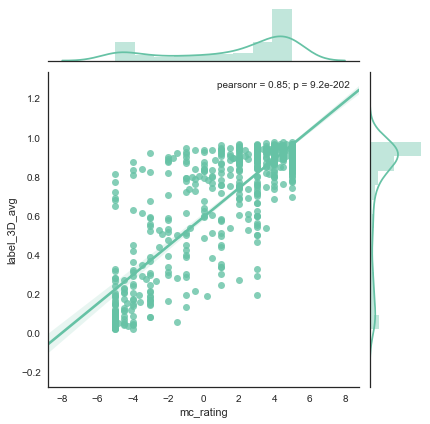

In [242]:
sns.jointplot('mc_rating', 'label_3D_avg', to3D, kind='reg')

In [158]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


def run_XGmodel(X, y, test_size=0.33, seed=7):

    #seed = 7
    #test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=seed,
                                                        stratify=y)

    # make sure everyone has a vote in the train and test
    #assert(np.isfinite(X_train).sum(0).all())
    #assert(np.isfinite(X_test).sum(0).all())

    model = XGBClassifier()

    # parameters to tune
    learning_rate = [0.001, 0.01, 0.1]
    n_estimators = [200, 600]
    max_depth = [2, 6, 8]

    # run the grid search
    param_grid = dict(learning_rate=learning_rate,
                      max_depth=max_depth,
                      n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss",
                               n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X_train, y_train)

    # results

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print(mean, stdev, param)

    # make predictions for test data
    # y_pred = model.predict(X_test)
    y_pred = grid_result.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    # log["Accuracy: %.2f%%"] = (accuracy * 100.0)
    print("accuracy", accuracy)

    y_pred_prob = grid_result.predict_proba(X_test)[:, 1]

    B = grid_result.best_estimator_.get_booster()
    fscores = B.get_fscore()
    fdf = pd.DataFrame([fscores]).T.rename(columns={0: 'F'})
    #print(fdf)
    fpr, tpr, _ = roc_curve(y_test==1, y_pred_prob)
    a = auc(fpr, tpr)
    

    return dict(fpr=fpr, tpr=tpr, auc=a, train_shape=X_train.shape[0], test_shape = X_test.shape[0], fscores=fdf, model=grid_result.best_estimator_)

## MRIQC

In [126]:
from nipype.utils.filemanip import load_json
js = load_json("mridata.json")

In [251]:
mriqc = pd.DataFrame(js['points'])
mriqc['id'] = "sub-" + mriqc['id'] + "_T1w"
mriqc.set_index('id', inplace=True)

In [252]:
notinc = ['average_vote', 'group']
mriqc = mriqc[[c for c in mriqc.columns if not c in notinc]]
mriqc.shape

(727, 68)

In [129]:
mriqc_gold = mriqc[mriqc.index.isin(labels['passing_names'] + labels['failing_names'])]
mriqc_gold.loc[mriqc_gold.index.isin(labels['passing_names']), 'truth'] = 1
mriqc_gold.loc[mriqc_gold.index.isin(labels['failing_names']), 'truth'] = 0
#mriqc_gold.head()

/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [130]:
X_mriqc = mriqc_gold[mriqc_gold.columns[:-1]].values
y_mriqc = mriqc_gold.truth.values
run_XGmodel(X_mriqc, y_mriqc)


accuracy 0.985074626866


{'auc': 0.99196428571428563,
 'fpr': array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.28125,  0.28125,  0.375  ,  0.5    ,  0.75   ,
         0.8125 ,  0.84375,  0.90625,  1.     ]),
 'fscores':       F
 f0   16
 f1    1
 f14  12
 f30   2
 f32  13
 f39   2
 f44   1
 f47   1
 f48   8
 f49   3
 f56   1
 f57  25
 f58  11
 f62  13
 f7   10
 f9    2,
 'test_shape': 67,
 'tpr': array([ 0.22857143,  0.34285714,  0.4       ,  0.51428571,  0.62857143,
         0.71428571,  0.97142857,  0.97142857,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,  1.        ]),
 'train_shape': 135}

In [197]:
mqc = []
for i in [0.33, 0.4, 0.5, 0.6, 0.7, 0.75, 0.78, 0.8, 0.85, 0.9, 0.96]:
    mqc.append(run_XGmodel(X_mriqc, y_mriqc, i))

accuracy 0.985074626866
accuracy 0.987654320988
accuracy 0.980198019802
accuracy 0.983606557377
accuracy 0.957746478873
accuracy 0.973684210526
accuracy 0.96835443038
accuracy 0.962962962963
accuracy 0.924418604651
accuracy 0.89010989011
accuracy 0.927835051546


In [198]:
[a['train_shape'] for a in mqc]

[135, 121, 101, 80, 60, 50, 44, 40, 30, 20, 8]

In [199]:
[a['auc'] for a in mqc]

[0.99196428571428563,
 0.99571603427172584,
 0.99724192277383761,
 0.99811066126855597,
 0.99681592039801004,
 0.99565292992523036,
 0.99581724581724584,
 0.99602203182374538,
 0.9709673043006376,
 0.96881056201550386,
 0.92883815213912302]

In [255]:
mriqc['mriqc_pred_xg'] = mqc[0]['model'].predict_proba(mriqc.values)[:,1]
mriqc.head()

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,mriqc_pred_xg
id,,,,,,,,,,,,,,,,,,,,,
sub-NDARAA075AMK_T1w,0.401338,3.344635,0.572430,174.539413,3.085544,3.196753,3.154720,2.905160,0.185510,0.481902,...,1000.011719,163914.0,878.356732,1117.456946,73.577469,0.203075,0.528169,0.547186,0.661029,0.992338
sub-NDARAA536PTU_T1w,0.362474,3.621342,0.575308,473.510345,3.161872,3.351265,3.201410,2.932940,0.181488,0.476988,...,1000.018616,156213.0,870.229175,1102.131396,70.268486,0.182377,0.512774,0.516899,0.593028,0.995848
sub-NDARAA948VFH_T1w,0.297878,4.125184,0.545416,4884.107422,3.922949,3.929622,3.877175,3.962050,0.150669,0.510822,...,1000.017395,338940.0,894.432498,1079.413721,54.620735,0.216688,0.534772,0.524811,0.548028,0.995848
sub-NDARAC853DTE_T1w,0.676058,1.941620,0.550638,1023.677917,3.900360,4.012530,3.603725,4.084825,0.192333,0.441902,...,1000.080688,375876.0,865.664337,1187.690247,99.957100,0.184210,0.477631,0.482773,0.541348,0.006068
sub-NDARAC904DMU_T1w,0.566243,2.210376,0.622120,588.529785,4.179836,4.207371,4.046712,4.285425,0.209088,0.437881,...,1000.017944,353961.0,873.198547,1184.168823,96.117752,0.180289,0.470822,0.483930,0.533840,0.011922


In [258]:
to3D.head()

predicted_label                                          \
slice_idx                        0.0       1.0       2.0       3.0       4.0   
subject                                                                        
sub-NDARAA075AMK_T1w        0.942518  0.765796  0.708444  0.893305  0.922348   
sub-NDARAA536PTU_T1w        0.972949  0.957473  0.963045  0.963418  0.925621   
sub-NDARAA948VFH_T1w        0.952820  0.975015  0.908336  0.966597  0.951152   
sub-NDARAC853DTE_T1w        0.093308  0.093928  0.004418  0.003276  0.031169   
sub-NDARAC904DMU_T1w        0.090159  0.026505  0.024158  0.008716  0.014594   

                     label_3D_avg mc_rating  
slice_idx                                    
subject                                      
sub-NDARAA075AMK_T1w     0.846482      3.50  
sub-NDARAA536PTU_T1w     0.956501      4.25  
sub-NDARAA948VFH_T1w     0.950784      4.50  
sub-NDARAC853DTE_T1w     0.045220     -5.00  
sub-NDARAC904DMU_T1w     0.032826     -5.00

In [263]:
#to3D['mriqc_pred_xg'] = mriqc['mriqc_pred_xg']

In [280]:
final_results = pd.merge(to3D, mriqc[['mriqc_pred_xg']], left_index=True, right_index=True)

/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [281]:
final_results.rename(columns={('label_3D_avg', ''): 'label_3D_avg', 
                              ('mc_rating', ''): 'mc_rating',
                              ('predicted_label', 0.0): 'predicted_label-0',
                              ('predicted_label', 1.0): 'predicted_label-1',
                              ('predicted_label', 2.0): 'predicted_label-2',
                              ('predicted_label', 3.0): 'predicted_label-3',
                              ('predicted_label', 4.0): 'predicted_label-4',
                              
                             }, inplace=True)

In [282]:
final_results.head()

,predicted_label-0,predicted_label-1,predicted_label-2,predicted_label-3,predicted_label-4,label_3D_avg,mc_rating,mriqc_pred_xg
sub-NDARAA075AMK_T1w,0.942518,0.765796,0.708444,0.893305,0.922348,0.846482,3.50,0.992338
sub-NDARAA536PTU_T1w,0.972949,0.957473,0.963045,0.963418,0.925621,0.956501,4.25,0.995848
sub-NDARAA948VFH_T1w,0.952820,0.975015,0.908336,0.966597,0.951152,0.950784,4.50,0.995848
sub-NDARAC853DTE_T1w,0.093308,0.093928,0.004418,0.003276,0.031169,0.045220,-5.00,0.006068
sub-NDARAC904DMU_T1w,0.090159,0.026505,0.024158,0.008716,0.014594,0.032826,-5.00,0.011922


In [284]:
img_labels

,n_votes,who,unique_who,mean,std,y_prob,subject,idx,predicted_label,slice_num,slice_idx
sub-NDARAA075AMK_T1w__ax_71,5,"{'Dylan', 'Dnkennedy', 'dnkennedy', 'gkiar', '...",5,0.800000,0.447214,0.082723,sub-NDARAA075AMK_T1w,3,0.942518,71,0.0
sub-NDARAA075AMK_T1w__ax_91,8,"{'Dylan', 'binarybottle', 'Dnkennedy', 'arokem'}",4,0.500000,0.534522,0.975416,sub-NDARAA075AMK_T1w,4,0.765796,91,1.0
sub-NDARAA075AMK_T1w__ax_111,6,"{'Dylan', 'vkeshavan', 'Dnkennedy', 'jyeatman ...",6,1.000000,0.000000,0.986059,sub-NDARAA075AMK_T1w,0,0.708444,111,2.0
sub-NDARAA075AMK_T1w__ax_131,6,"{'gkiar', 'pbellec', 'sliew', 'ekubota', 'cjma...",5,0.500000,0.547723,0.955134,sub-NDARAA075AMK_T1w,1,0.893305,131,3.0
sub-NDARAA075AMK_T1w__ax_151,3,"{'sliew', 'binarybottle', 'pdonnelly'}",3,0.666667,0.577350,0.659737,sub-NDARAA075AMK_T1w,2,0.922348,151,4.0
sub-NDARAA536PTU_T1w__ax_61,5,"{'Dylan', 'bv42', 'arokem'}",3,0.800000,0.447214,0.920376,sub-NDARAA536PTU_T1w,8,0.972949,61,0.0
sub-NDARAA536PTU_T1w__ax_81,6,{'akeshavan'},1,0.500000,0.547723,0.747955,sub-NDARAA536PTU_T1w,9,0.957473,81,1.0
sub-NDARAA536PTU_T1w__ax_101,10,"{'Dnkennedy', 'Kesh', 'akeshavan', 'gkiar', 'p...",5,0.600000,0.516398,0.852894,sub-NDARAA536PTU_T1w,5,0.963045,101,2.0
sub-NDARAA536PTU_T1w__ax_121,6,"{'Dylan', 'binarybottle', 'Dnkennedy', 'cjmark...",4,1.000000,0.000000,0.984351,sub-NDARAA536PTU_T1w,6,0.963418,121,3.0
sub-NDARAA536PTU_T1w__ax_141,7,"{'anisha', 'Dnkennedy', 'Kesh', 'pdonnelly'}",4,0.714286,0.487950,0.943779,sub-NDARAA536PTU_T1w,7,0.925621,141,4.0


In [290]:
final_results['braindr_images'] = final_results.index.map(lambda x: img_labels[img_labels.subject==x].sort_values('slice_idx').index.values)

In [302]:
final_results.reset_index().to_json("final_results-braindr-full-v0.0.json", orient="records")

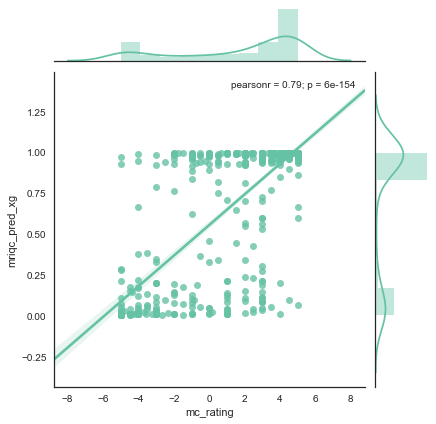

In [279]:
sns.jointplot('mc_rating', 'mriqc_pred_xg', final_results, kind='reg')

(array([ 156.,   29.,   12.,    8.,    3.,    7.,    6.,    7.,    7.,  492.]),
 array([ 0.00606803,  0.10504603,  0.20402404,  0.30300204,  0.40198004,
         0.50095805,  0.59993605,  0.69891405,  0.79789205,  0.89687006,
         0.99584806]),
 <a list of 10 Patch objects>)

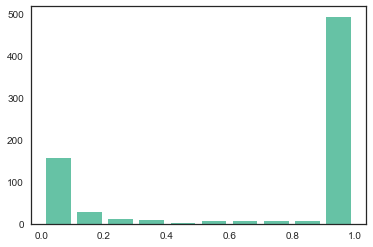

In [225]:
plt.hist(mqc[0]['model'].predict_proba(mriqc.values)[:,1], rwidth=0.8)

In [141]:
run_XGmodel(X_mriqc, y_mriqc, 0.96, 7)

accuracy 0.927835051546


{'auc': 0.92883815213912302,
 'fpr': array([ 0.        ,  0.05494505,  1.        ]),
 'fscores':     F
 f0  1,
 'test_shape': 194,
 'tpr': array([ 0.        ,  0.91262136,  1.        ]),
 'train_shape': 8}

### todo: Also save roc curve data

### todo: feature importance plot for mriqc

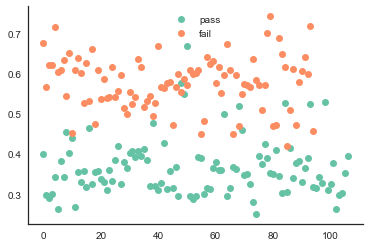

In [142]:
plt.plot(mriqc_gold[mriqc_gold.truth==1]['cjv'].values, lw=0, marker="o", label="pass")
plt.plot(mriqc_gold[mriqc_gold.truth==0]['cjv'].values, lw=0, marker="o", label="fail")
plt.legend()
sns.despine()